In [1]:
import numpy as np
v = 1.0
exc = np.nan
threshold = 1e-6

print(not (exc - threshold < v and v < exc + threshold))

True


In [2]:
# Load modules and set-up test problem
import sys
# sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt

import cuqi
from cuqi.testproblem import Deconvolution1D, Deconvolution2D
from cuqi.distribution import Gaussian, Gamma, JointDistribution, GMRF
from cuqi.implicitprior import RegularizedGaussian, RegularizedGMRF
from cuqi.problem import BayesianProblem
from cuqi.experimental.mcmc import RegularizedLinearRTO, HybridGibbs, Conjugate, LinearRTO

from cuqi.operator import FirstOrderFiniteDifference, SecondOrderFiniteDifference


# Set seed
np.random.seed(24601)


Text(0.5, 1.0, 'Data')

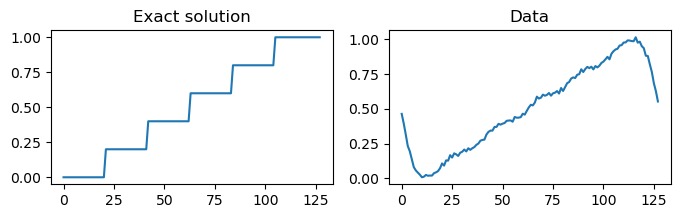

In [3]:
n = 128

x_true = np.zeros(n)

num_steps = 6
step_width = int(n/num_steps)
step_size = 1.0/(num_steps-1)
for i in range(1,num_steps):
    x_true[i*step_width:] += step_size

A, y_data, info = Deconvolution1D(dim=n, phantom=x_true, PSF_param = 5).get_components()

plt.figure(figsize = (8,2))
plt.subplot(1,2,1)
info.exactSolution.plot()
plt.title("Exact solution")

plt.subplot(1,2,2)
y_data.plot()
plt.title("Data")

Sample: 100%|██████████| 1000/1000 [00:03<00:00, 253.64it/s, acc rate: 100.00%]


Plotting 5 randomly selected samples


Text(0.5, 1.0, 'random samples')

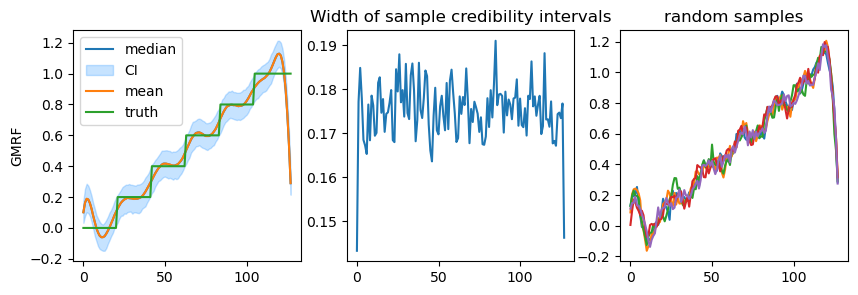

In [4]:
x = GMRF(np.zeros(n), prec = 500)
y  = Gaussian(A@x, 0.001)

joint = JointDistribution(x, y)
posterior = joint(y=y_data)

num_samples = 1000
num_burnin = 100
sampler = LinearRTO(posterior) 
sampler.sample(num_samples, num_burnin)

samples = sampler.get_samples()

plt.figure(figsize = (10,3))
plt.subplot(1,3,1)
samples.plot_median() # Median is a more representative point-estimate for this distribution
samples.plot_ci()
plt.plot(info.exactSolution)
plt.legend(["median", "CI", "mean", "truth"])
plt.ylabel("GMRF")

plt.subplot(1,3,2)
samples.plot_ci_width()

plt.subplot(1,3,3)
samples.plot()
plt.title("random samples")

In [5]:

def ProjectSimplex(x, radius = 1):
    ''' Condat, Fast projection onto the simplex and the l1 ball
        worst case O(n^2), average case O(nlogn)
        Technically not the faster algorithm, but the simplest
    '''
    u = np.flip(np.sort(x)) # worst case: O(n^2), average case: O(nlogn)
    K = len(x)-1
    accum = np.sum(u)
    while (accum - radius)/(K+1) >= u[K] and K > 0:
        accum -= u[K]
        K -= 1
    tau = (accum - radius)/(K+1)
    return np.maximum(x-tau, 0)

from cuqi.solver import ProjectNonnegative, ProjectBox

In [8]:
from scipy.optimize import isotonic_regression

priors = [
    #RegularizedGaussian(0.5*np.ones(n), 0.1, regularization = "tv", strength = 25),
    #RegularizedGaussian(0.5*np.ones(n), 0.1, proximal = [(lambda z, _: ProjectNonnegative(z),FirstOrderFiniteDifference(A.domain_geometry.par_dim, bc_type='neumann'))]),
    RegularizedGaussian(0.5*np.ones(n), 0.1, constraint = "increasing"),
    #RegularizedGaussian(0.5*np.ones(n), 0.1, proximal = [(lambda z, _: ProjectBox(z, lower = 0.0, upper = 0.2), FirstOrderFiniteDifference(A.domain_geometry.par_dim, bc_type='neumann'))]),
    #RegularizedGaussian(0.5*np.ones(n), 0.1, proximal = [(lambda z, _: ProjectSimplex(z, radius = 1), FirstOrderFiniteDifference(A.domain_geometry.par_dim, bc_type='neumann'))])
]

names = [
    #"TV",
    "Monotone",
    #"Bounded jumps",
    #"Bounded TV"]

num_samples = 100
num_burnin = 50
all_samples = []

for i, prior in enumerate(priors):
    x = prior
    y  = Gaussian(A@x, 0.001)

    joint = JointDistribution(x, y)
    posterior = joint(y=y_data)

    sampler = RegularizedLinearRTO(posterior,
                                    maxit=100,
                                    penalty_parameter = 100) 
    sampler.sample(num_samples + num_burnin)

    samples = sampler.get_samples()
    samples = samples.burnthin(num_burnin)
    all_samples += [samples]

SyntaxError: '[' was never closed (1382486807.py, line 11)

In [9]:
plt.figure(figsize = (12, 12))

for i in range(4):
    
    plt.subplot(len(priors),3,3*i+1)
    all_samples[i].plot_median() # Median is a more representative point-estimate for this distribution
    all_samples[i].plot_ci()
    plt.plot(info.exactSolution)
    plt.legend(["median", "CI", "mean", "truth"])
    plt.ylabel(names[i])

    plt.subplot(len(priors),3,3*i+2)
    all_samples[i].plot_ci_width()

    plt.subplot(len(priors),3,3*i+3)
    all_samples[i].plot()
    plt.title("random samples")

plt.tight_layout()
plt.show()

NameError: name 'priors' is not defined

<Figure size 1200x1200 with 0 Axes>

In [ ]:
n = 128

x_true = np.zeros(n)

for i, x in enumerate(np.linspace(0,1,n)):
    x_true[i] = (x-0.5)**4

A, y_data, info = Deconvolution1D(dim=n, phantom=x_true, PSF_param = 5).get_components()

plt.figure(figsize = (8,2))
plt.subplot(1,2,1)
info.exactSolution.plot()
plt.title("Exact solution")

plt.subplot(1,2,2)
y_data.plot()
plt.title("Data")

In [ ]:
x = GMRF(np.zeros(n), prec = 1e4)
y  = Gaussian(A@x, 0.001)

joint = JointDistribution(x, y)
posterior = joint(y=y_data)

num_samples = 1000
num_burnin = 100
sampler = LinearRTO(posterior) 
sampler.sample(num_samples, num_burnin)

samples = sampler.get_samples()

plt.figure(figsize = (10,3))
plt.subplot(1,3,1)
samples.plot_median() # Median is a more representative point-estimate for this distribution
samples.plot_ci()
plt.plot(info.exactSolution)
plt.legend(["median", "CI", "mean", "truth"])
plt.ylabel("GMRF")

plt.subplot(1,3,2)
samples.plot_ci_width()

plt.subplot(1,3,3)
samples.plot()
plt.title("random samples")

In [ ]:
SecondOrderFiniteDifference(A.domain_geometry.par_dim, bc_type='neumann')

In [ ]:
from cuqi.solver import ProximalL1

priors = [
    #RegularizedGaussian(0.5*np.ones(n), 0.1, regularization = "tv", strength = 25),
    RegularizedGaussian(0.5*np.ones(n), 0.1, constraint="convex"),
    #RegularizedGaussian(0.5*np.ones(n), 0.1, proximal = [(lambda z, scale: ProximalL1(z, 10*scale), SecondOrderFiniteDifference(A.domain_geometry.par_dim, bc_type='neumann'))])
]

names = ["TV", "Convex", "Sparse 2nd order differences"]

num_samples = 100
num_burnin = 50
all_samples = []

for i, prior in enumerate(priors):
    x = prior
    y  = Gaussian(A@x, 0.001)

    joint = JointDistribution(x, y)
    posterior = joint(y=y_data)

    sampler = RegularizedLinearRTO(posterior,
                                    maxit=200,
                                    penalty_parameter=1e6) 
    sampler.sample(num_samples + num_burnin)

    samples = sampler.get_samples()
    samples = samples.burnthin(num_burnin)
    all_samples += [samples]

In [ ]:
plt.figure(figsize = (12, 3*len(priors)))

for i in range(len(priors)):
    
    plt.subplot(len(priors),3,3*i+1)
    all_samples[i].plot_median() # Median is a more representative point-estimate for this distribution
    all_samples[i].plot_ci()
    plt.plot(info.exactSolution)
    plt.legend(["median", "CI", "mean", "truth"])
    plt.ylabel(names[i])

    plt.subplot(len(priors),3,3*i+2)
    all_samples[i].plot_ci_width()

    plt.subplot(len(priors),3,3*i+3)
    all_samples[i].plot()
    plt.title("random samples")

plt.tight_layout()
plt.show()